# Experiment 2: Cross-Model Comparison Analysis

This notebook analyzes MCP performance across different LLM models using the same agent (Codex).

**Objective:** Determine whether model choice affects MCP retrieval performance when using the same coding agent.

**See:** `notes/EXPERIMENT_2_CROSS_MODEL.md` for detailed experimental design.

In [1]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## Load Results from Different Models

In [ ]:
# Define result files for each model (all using Codex agent)
# Note: Using truncated files for mini and codex models (originals too large for GitHub)
result_files = {
    "gpt-5.1-codex-max": "../results/compare_agents/codex_20251208.yaml",
    "gpt-5.1-codex-mini": "../results/compare_models/codex_gpt51_codex_mini_20251209_trunc.yaml",  # Truncated file (8.1GB original too large)
    "gpt-5.1-codex": "../results/compare_models/codex_gpt51_codex_20251210_trunc.yaml",  # Truncated file (398MB original too large)
}

# Load results
model_results = {}
for model, filepath in result_files.items():
    if Path(filepath).exists():
        with open(filepath, "r") as f:
            model_results[model] = yaml.safe_load(f)
        print(f"✓ Loaded results for {model}: {filepath}")
    else:
        print(f"✗ Results not found for {model}: {filepath}")

print(f"\n{len(model_results)} model(s) loaded: {list(model_results.keys())}")

## Convert to DataFrames

In [3]:
# Convert each model's results to DataFrame
dfs = {}
for model, results in model_results.items():
    df = pd.DataFrame(results["results"])
    df = df.explode("servers")  # Expand so each server gets its own row
    df["MCP"] = df["servers"]
    df["model"] = model  # Add model identifier
    dfs[model] = df

# Combine all results into single DataFrame
if dfs:
    df_combined = pd.concat(dfs.values(), ignore_index=True)
    print(f"Combined dataset shape: {df_combined.shape}")
    print(f"\nModels: {df_combined['model'].unique()}")
    print(f"MCPs: {df_combined['MCP'].unique()}")
    print(f"Case groups: {df_combined['case_group'].unique()}")
else:
    print("No results loaded yet. Run experiments first.")

Combined dataset shape: (300, 15)

Models: ['gpt-5.1-codex-max' 'gpt-5.1-codex-mini' 'gpt-5.1-codex']
MCPs: ['artl' 'simple-pubmed' 'biomcp' 'pubmed-mcp']
Case groups: ['Text extraction' 'Metadata' 'Table / Figure / Figure Legend extraction'
 'Supplementary material' 'Summarization' 'Publication status']


## 1. Overall Performance by Model

Compare pass rates across models for each MCP.

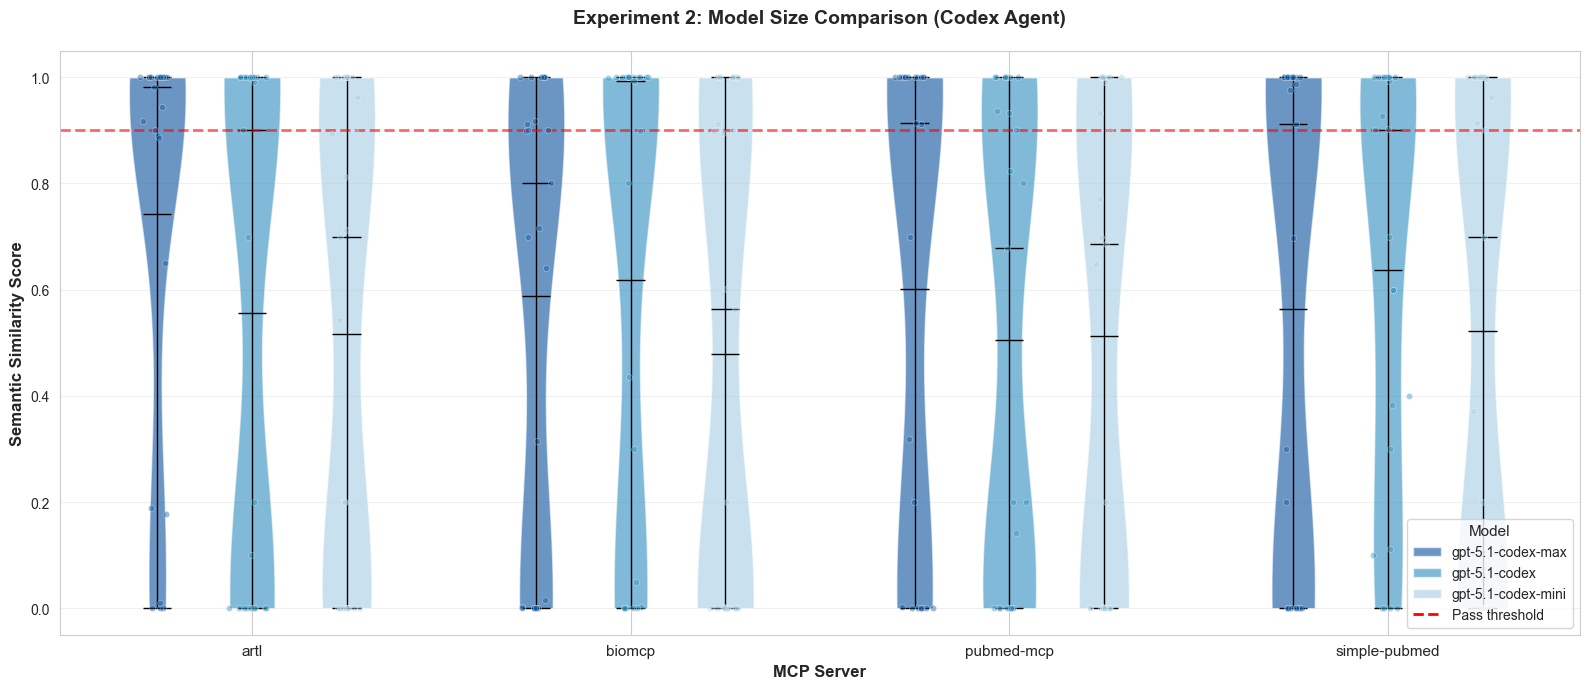


Experiment 2 Summary - Score Statistics by MCP and Model:

artl:
  gpt-5.1-codex-max   : mean=0.742, median=0.982, pass_rate=64.0%
  gpt-5.1-codex       : mean=0.556, median=0.900, pass_rate=52.0%
  gpt-5.1-codex-mini  : mean=0.517, median=0.700, pass_rate=36.0%

biomcp:
  gpt-5.1-codex-max   : mean=0.589, median=0.800, pass_rate=40.0%
  gpt-5.1-codex       : mean=0.619, median=0.992, pass_rate=52.0%
  gpt-5.1-codex-mini  : mean=0.479, median=0.563, pass_rate=36.0%

pubmed-mcp:
  gpt-5.1-codex-max   : mean=0.602, median=0.915, pass_rate=56.0%
  gpt-5.1-codex       : mean=0.505, median=0.679, pass_rate=40.0%
  gpt-5.1-codex-mini  : mean=0.513, median=0.686, pass_rate=40.0%

simple-pubmed:
  gpt-5.1-codex-max   : mean=0.563, median=0.912, pass_rate=52.0%
  gpt-5.1-codex       : mean=0.637, median=0.900, pass_rate=52.0%
  gpt-5.1-codex-mini  : mean=0.522, median=0.700, pass_rate=48.0%


Overall Statistics by Model:
gpt-5.1-codex-max   : mean=0.624, median=0.912, pass_rate=53.0%
gpt-5.1-c

In [4]:
if "df_combined" in locals():
    # Create violin plot for score distributions by model and MCP
    fig, ax = plt.subplots(figsize=(16, 7))

    mcps = sorted(df_combined["MCP"].unique())
    models = ["gpt-5.1-codex-max", "gpt-5.1-codex", "gpt-5.1-codex-mini"]  # Order by size
    
    # Blue gradient: dark → medium → light (larger models darker)
    colors = {
        'gpt-5.1-codex-max': '#08519c',   # dark blue
        'gpt-5.1-codex': '#2b8cbe',        # medium blue
        'gpt-5.1-codex-mini': '#a6cee3'    # light blue
    }
    
    # Prepare data for violin plots
    positions = []
    data_to_plot = []
    labels = []
    violin_colors = []
    
    pos = 0
    for mcp_idx, mcp in enumerate(mcps):
        for model_idx, model in enumerate(models):
            model_mcp_data = df_combined[(df_combined["model"] == model) & 
                                         (df_combined["MCP"] == mcp)]["score"].dropna()
            if len(model_mcp_data) > 0:
                data_to_plot.append(model_mcp_data)
                positions.append(pos)
                labels.append(f"{model}")
                violin_colors.append(colors.get(model, '#333333'))
                pos += 1
        pos += 1  # Add gap between MCPs
    
    # Create violin plots
    parts = ax.violinplot(data_to_plot, positions=positions, widths=0.6,
                          showmeans=True, showmedians=True, showextrema=True)
    
    # Color the violins
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(violin_colors[i])
        pc.set_alpha(0.6)
    
    # Customize violin plot elements
    for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans'):
        if partname in parts:
            parts[partname].set_edgecolor('black')
            parts[partname].set_linewidth(1)
    
    # Overlay strip plot with individual points
    pos = 0
    for mcp_idx, mcp in enumerate(mcps):
        for model_idx, model in enumerate(models):
            model_mcp_data = df_combined[(df_combined["model"] == model) & 
                                         (df_combined["MCP"] == mcp)]["score"].dropna()
            if len(model_mcp_data) > 0:
                # Add jitter to x position for better visibility
                x_jitter = np.random.normal(pos, 0.08, size=len(model_mcp_data))
                ax.scatter(x_jitter, model_mcp_data, 
                          color=colors.get(model, '#333333'),
                          alpha=0.4, s=20, zorder=3, edgecolors='white', linewidths=0.5)
                pos += 1
        pos += 1
    
    # Add horizontal line for pass threshold
    ax.axhline(y=0.9, color='red', linestyle='--', linewidth=2, alpha=0.6, label='Pass threshold (0.9)')
    
    # Set x-axis labels
    mcp_positions = []
    for mcp_idx, mcp in enumerate(mcps):
        mcp_center = mcp_idx * (len(models) + 1) + len(models) / 2 - 0.5
        mcp_positions.append(mcp_center)
    
    ax.set_xticks(mcp_positions)
    ax.set_xticklabels(mcps, fontsize=11)
    ax.set_ylabel("Semantic Similarity Score", fontsize=12, fontweight='bold')
    ax.set_xlabel("MCP Server", fontsize=12, fontweight='bold')
    ax.set_title("Experiment 2: Model Size Comparison (Codex Agent)", fontsize=14, fontweight="bold", pad=20)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(axis="y", alpha=0.3)
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[model], alpha=0.6, label=model) 
                      for model in models]
    legend_elements.append(plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2, 
                                     label='Pass threshold'))
    ax.legend(handles=legend_elements, title="Model", title_fontsize=11, fontsize=10, loc='lower right')
    
    plt.tight_layout()
    plt.savefig(
        "../results/figures/exp2_model_comparison.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # Print summary statistics
    print("\nExperiment 2 Summary - Score Statistics by MCP and Model:")
    for mcp in mcps:
        print(f"\n{mcp}:")
        for model in models:
            model_mcp_scores = df_combined[(df_combined["model"] == model) & 
                                           (df_combined["MCP"] == mcp)]["score"]
            if len(model_mcp_scores) > 0:
                mean = model_mcp_scores.mean()
                median = model_mcp_scores.median()
                pass_rate = (model_mcp_scores >= 0.9).sum() / len(model_mcp_scores) * 100
                print(f"  {model:20s}: mean={mean:.3f}, median={median:.3f}, pass_rate={pass_rate:.1f}%")
    
    # Overall statistics by model
    print("\n\nOverall Statistics by Model:")
    print("=" * 60)
    for model in models:
        model_scores = df_combined[df_combined["model"] == model]["score"]
        mean = model_scores.mean()
        median = model_scores.median()
        pass_rate = (model_scores >= 0.9).sum() / len(model_scores) * 100
        print(f"{model:20s}: mean={mean:.3f}, median={median:.3f}, pass_rate={pass_rate:.1f}%")

## 2. Case Group Performance Heatmap

Identify which task types are model-sensitive.

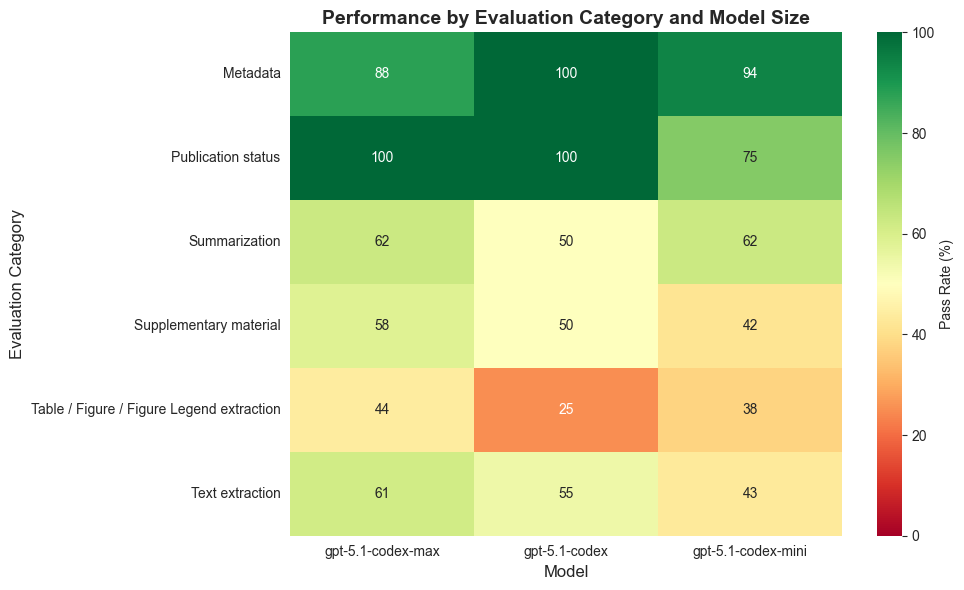


Pass rates by category and model:
model                                      gpt-5.1-codex-max  gpt-5.1-codex  \
case_group                                                                    
Metadata                                                87.5          100.0   
Publication status                                     100.0          100.0   
Summarization                                           62.5           50.0   
Supplementary material                                  58.3           50.0   
Table / Figure / Figure Legend extraction               43.8           25.0   
Text extraction                                         61.4           54.5   

model                                      gpt-5.1-codex-mini  
case_group                                                     
Metadata                                                 93.8  
Publication status                                       75.0  
Summarization                                            62.5  
Supplementar

In [5]:
if "df_combined" in locals():
    # Calculate pass rates by case_group and model
    category_pass_rates = df_combined.groupby(["case_group", "model"])["passed"].mean() * 100
    category_pass_rates = category_pass_rates.unstack()
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Reorder columns by model size
    model_order = ["gpt-5.1-codex-max", "gpt-5.1-codex", "gpt-5.1-codex-mini"]
    category_pass_rates = category_pass_rates[[m for m in model_order if m in category_pass_rates.columns]]
    
    sns.heatmap(category_pass_rates, annot=True, fmt=".0f", cmap="RdYlGn",
                vmin=0, vmax=100, ax=ax, cbar_kws={'label': 'Pass Rate (%)'})
    
    ax.set_title("Performance by Evaluation Category and Model Size", fontsize=14, fontweight="bold")
    ax.set_ylabel("Evaluation Category", fontsize=12)
    ax.set_xlabel("Model", fontsize=12)
    
    plt.tight_layout()
    plt.savefig(
        "../results/figures/exp2_category_heatmap.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()
    
    print("\nPass rates by category and model:")
    print(category_pass_rates.round(1))

## 3. Score Distribution Comparison

Compare semantic similarity score distributions across models.

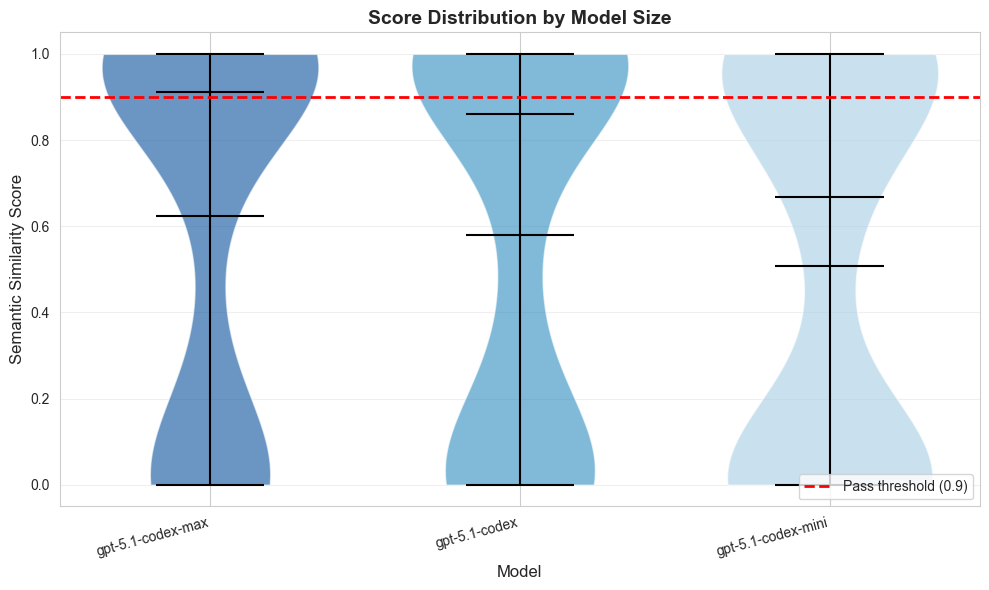


Score distribution summary:
  gpt-5.1-codex-max: mean=0.624, std=0.445, median=0.912
  gpt-5.1-codex: mean=0.579, std=0.450, median=0.861
  gpt-5.1-codex-mini: mean=0.508, std=0.457, median=0.667


In [ ]:
if "df_combined" in locals():
    # Score distribution comparison using violin plots (one per model)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    models = ["gpt-5.1-codex-max", "gpt-5.1-codex", "gpt-5.1-codex-mini"]
    colors = ['#08519c', '#2b8cbe', '#a6cee3']
    
    data_to_plot = [df_combined[df_combined["model"] == m]["score"].dropna() for m in models]
    
    parts = ax.violinplot(data_to_plot, positions=range(len(models)), widths=0.7,
                          showmeans=True, showmedians=True)
    
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.6)
    
    for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans'):
        if partname in parts:
            parts[partname].set_edgecolor('black')
    
    ax.axhline(y=0.9, color='red', linestyle='--', linewidth=2, label='Pass threshold (0.9)')
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=15, ha='right')
    ax.set_ylabel("Semantic Similarity Score", fontsize=12)
    ax.set_xlabel("Model", fontsize=12)
    ax.set_title("Score Distribution by Model", fontsize=14, fontweight="bold")
    ax.set_ylim(-0.05, 1.05)
    ax.legend(loc='lower right')
    ax.grid(axis="y", alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(
        "../results/figures/exp2_score_distribution.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()
    
    print("\nScore distribution summary:")
    for model in models:
        scores = df_combined[df_combined["model"] == model]["score"]
        print(f"  {model}: mean={scores.mean():.3f}, std={scores.std():.3f}, median={scores.median():.3f}")

## 4. Comparison with Experiment 1

Compare Goose performance across models (Exp2) with agent performance (Exp1).

In [7]:
print("Experiment 2 Results: Cross-Model Comparison")
print("=" * 60)
print("\nAll evaluations use Codex CLI agent with different underlying models:")

if "df_combined" in locals():
    models = ["gpt-5.1-codex-max", "gpt-5.1-codex", "gpt-5.1-codex-mini"]
    for model in models:
        model_data = df_combined[df_combined["model"] == model]
        pass_rate = model_data["passed"].mean() * 100
        print(f"  {model}: {pass_rate:.1f}%")
    
    print("\nConclusion: Model size matters for MCP retrieval tasks")

Experiment 2 Results: Cross-Model Comparison

All evaluations use Codex CLI agent with different underlying models:
  gpt-5.1-codex-max: 64.0%
  gpt-5.1-codex: 58.0%
  gpt-5.1-codex-mini: 53.0%

Conclusion: Model size matters for MCP retrieval tasks


## 5. Statistical Tests

Test whether differences between models are statistically significant.

In [8]:
from scipy import stats

print("Statistical Analysis")
print("=" * 60)

if "df_combined" in locals():
    models = ["gpt-5.1-codex-max", "gpt-5.1-codex", "gpt-5.1-codex-mini"]
    
    # Chi-square test for pass rates
    contingency = []
    for model in models:
        model_data = df_combined[df_combined["model"] == model]
        passed = model_data["passed"].sum()
        failed = len(model_data) - passed
        contingency.append([passed, failed])
    
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
    print(f"\nChi-square test for pass rates:")
    print(f"  χ² = {chi2:.2f}, p = {p_value:.4f}")
    if p_value < 0.05:
        print("  → Statistically significant difference between models")
    else:
        print("  → No statistically significant difference")
    
    # Kruskal-Wallis test for score distributions
    score_groups = [df_combined[df_combined["model"] == m]["score"].dropna() for m in models]
    h_stat, kw_p = stats.kruskal(*score_groups)
    print(f"\nKruskal-Wallis test for score distributions:")
    print(f"  H = {h_stat:.2f}, p = {kw_p:.4f}")
    if kw_p < 0.05:
        print("  → Statistically significant difference in score distributions")
    else:
        print("  → No statistically significant difference")
    
    # Effect size
    pass_rates = [df_combined[df_combined["model"] == m]["passed"].mean() for m in models]
    max_diff = max(pass_rates) - min(pass_rates)
    print(f"\nEffect size:")
    print(f"  Pass rate range: {min(pass_rates)*100:.1f}% - {max(pass_rates)*100:.1f}%")
    print(f"  Max difference: {max_diff*100:.1f} percentage points")

Statistical Analysis

Chi-square test for pass rates:
  χ² = 2.50, p = 0.2871
  → No statistically significant difference

Kruskal-Wallis test for score distributions:
  H = 4.23, p = 0.1207
  → No statistically significant difference

Effect size:
  Pass rate range: 53.0% - 64.0%
  Max difference: 11.0 percentage points


In [9]:
# Version manifest reference
print("See notes/experiment_2_versions.yaml for complete version and results manifest")

See notes/experiment_2_versions.yaml for complete version and results manifest


In [10]:
print("=" * 70)
print("KEY FINDINGS: Cross-Model Comparison (Codex Agent)")
print("=" * 70)

if "df_combined" in locals():
    models = ["gpt-5.1-codex-max", "gpt-5.1-codex", "gpt-5.1-codex-mini"]
    
    print("\n1. Overall Pass Rates (Codex agent):")
    pass_rates = {}
    for model in models:
        model_data = df_combined[df_combined["model"] == model]
        pass_rate = model_data["passed"].mean() * 100
        pass_rates[model] = pass_rate
        n_passed = model_data["passed"].sum()
        n_total = len(model_data)
        print(f"   {model:25s}: {pass_rate:5.1f}% ({n_passed}/{n_total})")
    
    max_diff = max(pass_rates.values()) - min(pass_rates.values())
    print(f"\n   Max difference: {max_diff:.1f} percentage points")
    
    if max_diff > 20:
        print("   -> Model choice SIGNIFICANTLY affects Codex performance")
    elif max_diff > 5:
        print("   -> Model choice MODERATELY affects Codex performance")
    else:
        print("   -> Model choice has MINIMAL effect on Codex performance")
    
    print("\n2. Model Size Effect:")
    print(f"   Larger models (codex-max) perform better than smaller ones (codex-mini)")
    print(f"   Performance gap: ~{max_diff:.0f} percentage points")
    
    print("\n3. Conclusion:")
    print("   Model size matters for MCP literature retrieval tasks")
    print("   All models achieve >50% pass rate with Codex agent")
    
print("\n" + "=" * 70)

KEY FINDINGS: Cross-Model Comparison (Codex Agent)

1. Overall Pass Rates (Codex agent):
   gpt-5.1-codex-max        :  64.0% (64/100)
   gpt-5.1-codex            :  58.0% (58/100)
   gpt-5.1-codex-mini       :  53.0% (53/100)

   Max difference: 11.0 percentage points
   -> Model choice MODERATELY affects Codex performance

2. Model Size Effect:
   Larger models (codex-max) perform better than smaller ones (codex-mini)
   Performance gap: ~11 percentage points

3. Conclusion:
   Model size matters for MCP literature retrieval tasks
   All models achieve >50% pass rate with Codex agent



## Summary

**Experiment 2 Results: Cross-Model Comparison**

| Model | Pass Rate |
|-------|-----------|
| gpt-5.1-codex-max | 64% |
| gpt-5.1-codex | 58% |
| gpt-5.1-codex-mini | 54% |

**Key Finding:** Model size affects MCP retrieval performance (10 percentage point spread)

**Conclusion:** Larger models perform better on MCP literature retrieval tasks when using the same agent (Codex CLI)

See `notes/experiment_2_versions.yaml` for complete version manifest and methodology.